In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
import scipy
import random
import argparse

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import Resnet_multiscale_general as net

combos_file =  all_combos_5.npy
test_data.shape =  (1, 2076, 128)
model_depends.step_sizes=  [1, 5, 25]
load  original_model_D1_noise0.0.pt
load  original_model_D5_noise0.0.pt
load  original_model_D25_noise0.0.pt
timesteps =  2075
num_lines =  500


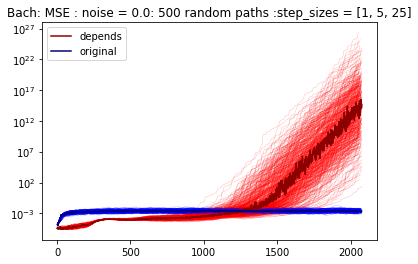

In [5]:

#===========================================================================================================
def find_ave_random_paths(t_list_list, mse_list):
    to_ave = np.zeros((num_lines, 10000, test_data.shape[-1]))
    i = 0 
    j = 4
    print(t_list_list[i][j])
    for i in range(num_lines):
        for j in range(len(t_list_list[i])):
            to_ave[i, int(t_list_list[i][j])] = mse_list[i][j]

    averages = np.zeros(10000)
    to_ave[to_ave == 0] = np.nan
#     means = np.nanmean(to_ave[:, 1:], axis=0)
    means = np.nanpercentile(to_ave[:, 1:], 50, axis = 0)
    stds = np.nanstd(to_ave[:, 1:], axis=0)
    percent_95 = np.nanpercentile(to_ave[:, 1:], 95, axis = 0)
    percent_5 = np.nanpercentile(to_ave[:, 1:], 5, axis = 0)

    mask = np.isfinite(means[:,0])
    ts = np.arange(1, 10000)

    return ts[mask], means[mask], stds[mask], percent_95[mask], percent_5[mask]
   
#===========================================================================================================

def predict_random_combo(model_depends, models_original, test_data, timesteps = 5000, to_plot=True):
    t = 0
    n_test_points, _, ndim = test_data.shape


    t_list = list()
    y_pred_list_depends = list()
    y_pred_list_original = list()

    indices = np.random.randint(0,len(step_sizes), int(timesteps/min(step_sizes)))
    steps = list()
    for i in range(len(indices)):
        steps.append(step_sizes[indices[i]])
        if sum(steps)>timesteps:
            break
    
    y_pred_list_depends = np.zeros((n_test_points, len(steps)-1, ndim))
    y_pred_list_original = np.zeros((n_test_points, len(steps)-1, ndim))
    y_preds_depends = torch.tensor(test_data[:, 0]).float()
    y_preds_original = torch.tensor(test_data[:, 0]).float()

    for i in range(len(steps)-1):
        this_pick = indices[i]
        this_step_size = steps[i]
        t+= this_step_size
        y_preds_depends = model_depends.forward(y_preds_depends, str(this_step_size))
        y_preds_original = models_original[this_pick].forward(y_preds_original)

        y_pred_list_depends[:,i] = y_preds_depends.detach().numpy()
        y_pred_list_original[:,i] = y_preds_original.detach().numpy()
        t_list.append(t)
        
    t_list = np.array(t_list)
    y_pred_list_depends = np.array(y_pred_list_depends)
    y_pred_list_original = np.array(y_pred_list_original)
    
    
    mse_depends = np.mean((y_pred_list_depends - test_data[:,t_list.astype(int)])**2, axis = (0,2))
    mse_original = np.mean((y_pred_list_original - test_data[:,t_list.astype(int)])**2, axis = (0,2))
    
    return y_pred_list_depends, y_pred_list_original, mse_depends, mse_original, t_list
#===========================================================================================================

spacial = False

override_step_list = True
step_sizes = [4, 8, 216]#[4, 8, 216]

small = 1

system = "Bach"
letter = 'a'
noise = 0.0
# timesteps = 5000
if 'KS' in system:
    override_step_list = False
    dt = 0.025
    arch = [512, 2048, 512]
    step_sizes = [1, 6, 36]#[4, 8, 216]
    spacial = True
    
elif 'Bach' in system:
    n_forward = 3
    override_step_list = False
    dt = 0.025
    arch = [128, 2048, 128]
    step_sizes  = [1, 5, 25]
    combos_file = "all_combos_5.npy"
    print('combos_file = ', combos_file)
    
elif 'fluid' in system:
    n_forward = 3
    override_step_list = False
    dt = 0.01
    arch = [22, 256, 22]
    step_sizes  = [1, 4, 16]
    combos_file = "all_combos_fluid4.npy"
    
elif  "VanDerPol" in system:
    smallest_step = 4
    dt = 0.01
    arch = [2, 512, 512, 512, 2]
    step_sizes = [4, 8, 16]
elif "Lorenz" in system:
    smallest_step = 16
    timesteps = 1000
    dt = 0.0005
    arch = [3, 1024, 1024, 1024, 3]
    step_sizes = [16, 32, 64]
    
elif "hyperbolic" in system:
    lr = 1e-4  
    smallest_step = 8
    step_sizes = [8, 16, 32]
    dt = 0.01
    arch = [2, 128, 128, 128, 2] 
elif  "cubic" in system:
    lr = 1e-4  
    smallest_step = 2
    dt = 0.01
    arch = [2, 256, 256, 256, 2] 
    step_sizes = [2, 4, 8]
elif "hopf" in system:
    lr = 1e-4  
    smallest_step = 4
    dt = 0.01
    arch = [3, 128, 128, 128, 3]
    step_sizes = [4, 8, 16]
else:
    print("system not available")
    raise SystemExit()

if small > 0:
    smallest_step = small
    if override_step_list:
        step_sizes = [smallest_step, smallest_step*2, smallest_step*4]
    
n_poss = 1773

# paths
data_dir = os.path.join('../../data/', system,)
model_dir = os.path.join('../../models/', system)


# load data
# train_data = np.load(os.path.join(data_dir, 'train_noise{}.npy'.format(noise)))
# try:
#     val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
# except:
#     #just use training data for all if validation and testing not there
#     print("validation not found, using trainin")
#     val_data= train_data
try:
    test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
except:
    #just use training data for all if validation and testing not there
    print("testing not found, using training ")
    test_data=train_data


n_test_points, _, ndim = test_data.shape

# n_train = train_data.shape[0]
# n_val = val_data.shape[0]
n_test = test_data.shape[0]

# print("train_data shape = ", train_data.shape)
# print("val_data shape = ", val_data.shape)
print("test_data.shape = ", test_data.shape)


#load depend model
model_name = 'model_{}_depends_stepsize{}_noise{}_{}.pt'.format(system, smallest_step, noise, letter)
model_depends = torch.load(os.path.join(model_dir, model_name), map_location='cpu')
model_depends.device = 'cpu'

print("model_depends.step_sizes= ", model_depends.step_sizes)
for step_size in model_depends.step_sizes:
    model_depends._modules[str(step_size)]._modules['activation'] = torch.nn.ReLU()

    
#load original models
# load models
models_original = list()
for step_size in model_depends.step_sizes:
    model_name = 'original_model_D{}_noise{}.pt'.format(step_size, noise, letter)
    print("load ", model_name)
    try:
        try:
            models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
        except:
            try:
#                 model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, letter)
                model_name = 'Bach_D{}.pt'.format(step_size)
                models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
            except:
                model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, 'b')
                models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
    except:
        print("done loading at {}".format(step_size))
        break
        

to_plot = False
timesteps = test_data.shape[1] - 1
#less for Lorenz
if "Lorenz" in system:
    timesteps = 1000
    
elif "KS" in system:
    timesteps = 1000
    
print("timesteps = ", timesteps)

        
# num_lines = 500
# mse_list_depends = list()
# mse_list_original = list()
# t_list_list = list()
# path_list = list()
# y_pred_list_depends = list()
# y_pred_list_original = list()


# #train all the random lines of both models
# for i in range(num_lines):
#     print("i = ", i)

#     y_preds_random_depends, y_preds_random_original, mse_random_depends, mse_random_original, t_list_random = predict_random_combo(model_depends, models_original, test_data, timesteps = timesteps, to_plot=False)
#     y_pred_list_depends.append(y_preds_random_depends[0,:])
#     y_pred_list_original.append(y_preds_random_original[0,:])
#     mse_list_depends.append(mse_random_depends)
#     mse_list_original.append(mse_random_original)
#     t_list_list.append(t_list_random)

# np.save(os.path.join(model_dir, 't_list_list.npy'), t_list_list)
# np.save(os.path.join(model_dir, 'mse_list_depends.npy'), mse_list_depends)
# np.save(os.path.join(model_dir, 'mse_list_original.npy'), mse_list_original)
# #find the average paths for both methods


# ts_depends, means_depends, stds_depends, percent_95_depends, percent_5_depends = find_ave_random_paths(t_list_list, mse_list_depends)
# ts_original, means_original, stds_original, percent_95_original, percent_5_original = find_ave_random_paths(t_list_list, mse_list_original)

# np.save(os.path.join(model_dir, 'ts_depends.npy'), ts_depends)
# np.save(os.path.join(model_dir, 'means_depends.npy'), means_depends)
# np.save(os.path.join(model_dir, 'stds_depends.npy'), stds_depends)
# np.save(os.path.join(model_dir, 'percent_95_depends.npy'), percent_95_depends)
# np.save(os.path.join(model_dir, 'percent_5_depends.npy'), percent_5_depends)
# np.save(os.path.join(model_dir, 'ts_original.npy'), ts_original)
# np.save(os.path.join(model_dir, 'means_original.npy'), means_original)
# np.save(os.path.join(model_dir, 'stds_original.npy'), stds_original)
# np.save(os.path.join(model_dir, 'percent_95_original.npy'), percent_95_original)
# np.save(os.path.join(model_dir, 'percent_5_original.npy'), percent_5_original)

t_list_list = np.load(os.path.join(model_dir, 't_list_list.npy'), allow_pickle=True)
mse_list_depends = np.load(os.path.join(model_dir, 'mse_list_depends.npy'), allow_pickle=True)
mse_list_original = np.load(os.path.join(model_dir, 'mse_list_original.npy'), allow_pickle=True)
y_pred_list_depends = np.load(os.path.join(model_dir, 'y_pred_list_depends.npy'), allow_pickle=True)
y_pred_list_original = np.load(os.path.join(model_dir, 'y_pred_list_original.npy'), allow_pickle=True)

ts_depends = np.load(os.path.join(model_dir, 'ts_depends.npy'))
means_depends = np.load(os.path.join(model_dir, 'means_depends.npy'))
stds_depends = np.load(os.path.join(model_dir, 'stds_depends.npy'))
percent_95_depends = np.load(os.path.join(model_dir, 'percent_95_depends.npy'))
percent_5_depends = np.load(os.path.join(model_dir, 'percent_5_depends.npy'))
ts_original = np.load(os.path.join(model_dir, 'ts_original.npy'))
means_original = np.load(os.path.join(model_dir, 'means_original.npy'))
stds_original = np.load(os.path.join(model_dir, 'stds_original.npy'))
percent_95_original = np.load(os.path.join(model_dir, 'percent_95_original.npy'))
percent_5_original = np.load(os.path.join(model_dir, 'percent_5_original.npy'))


num_lines = len(t_list_list)
print("num_lines = ", num_lines)



In [46]:
print(mse_list_depends.shape)
print(mse_list_depends[0].shape)
print(np.argmin(mse_list_depends[:][100]))
print(mse_list_depends[6][100])
print(mse_list_depends[7][100])

(500,)
(173,)
6
0.001870886632722906
0.00022730937448606008


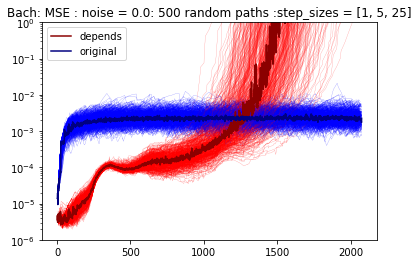

In [28]:
#####################################################################################################
#start of the plotting code

# graph the mse both themods with a random line for each trial and thicker line for average of mse
plt.figure()
for i in range(len(mse_list_depends)):
    plt.semilogy(t_list_list[i], mse_list_depends[i], 'r', linewidth = 0.25, alpha = 0.5)
    plt.semilogy(t_list_list[i], mse_list_original[i], 'b', linewidth = 0.25, alpha=0.5)

plt.semilogy(ts_depends, means_depends[:,0], color='darkred', label="depends")
plt.semilogy(ts_original, means_original[:,0], color='navy', label="original")
plt.legend()
plt.title(system + ": MSE : noise = " + str(noise) + ": " + str(num_lines) + " random paths :step_sizes = "+str(step_sizes))
plt.ylim([1e-6, 1])
plt.show()




(181, 128)
173


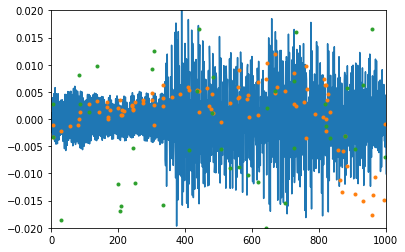

In [55]:
# data = np.load(os.path.join(data_dir, 'test_noise{}_full.npy'.format(noise)))
# print(data.shape)

idx = 5
y_preds_random_depends = y_pred_list_depends[idx]
y_preds_random_original = y_pred_list_original[idx]
print(y_preds_random_depends.shape)
print(len(t_list_list[0]))
plt.plot(test_data[0,:,0])
plt.plot(t_list_list[idx], y_preds_random_depends[:,0], '.')
plt.plot(t_list_list[idx], y_preds_random_original[:,0], '.')
plt.ylim([-.02, .02])
plt.xlim([0,1000])
plt.show()

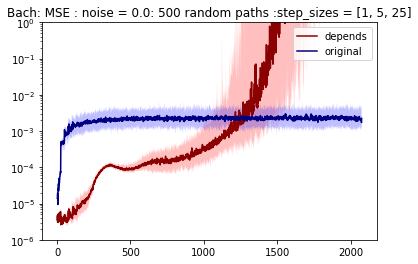

In [58]:
plt.figure()
# for i in range(len(mse_list_depends)):
#     plt.semilogy(t_list_list[i], mse_list_depends[i], 'r', linewidth = 0.25, alpha = 0.5)
#     plt.semilogy(t_list_list[i], mse_list_original[i], 'b', linewidth = 0.25, alpha=0.5)

plt.semilogy(ts_depends, means_depends[:,0], color='darkred', label="depends")
plt.semilogy(ts_original, means_original[:,0], color='navy', label="original")

n_stds = 1
plt.fill_between(ts_depends, percent_95_depends[:,0], percent_5_depends[:,0], facecolor='red', alpha=0.25)
plt.fill_between(ts_depends, percent_95_original[:,0], percent_5_original[:,0], facecolor='blue', alpha=0.25)

    
plt.ylim([1e-6, 1])
plt.legend()
plt.title(system + ": MSE : noise = " + str(noise) + ": " + str(num_lines) + " random paths :step_sizes = "+str(step_sizes))
plt.show()

In [19]:
print("test_data.shape = ", test_data.shape)


test_data.shape =  (1, 2076, 128)


In [ ]:
len(y_pred_list_depends)

In [ ]:
t_list_random[-1]

In [ ]:
y_pred_list_original

coupled_nn_V = y_pred_list_original[0]
coupled_nn_data = U[:, :22].dot(np.diag(s[:22]).dot(coupled_nn_V.T)).reshape(449, 199, -1)
print(coupled_nn_data.shape)

plt.imshow(coupled_nn_data[:,:,-1].T, vmin=-0.227793, vmax=1.30678)
plt.colorbar()
plt.title("original model")

In [ ]:
for i in range(len(y_pred_list_original)):
    coupled_nn_V = y_pred_list_original[i]
#     print(coupled_nn_V.shape)
    coupled_nn_data = U[:, :22].dot(np.diag(s[:22]).dot(coupled_nn_V.T)).reshape(449, 199, -1)
#     print(coupled_nn_data.shape)
#     fig = plt.figure(figsize=(12, 3))
    plt.plot(t_list_list[i], coupled_nn_data[100:110, 70:80, :].mean(0).mean(0), 'b.')
#     print(coupled_nn_data[100:110, 70:80, :].mean(0).mean(0).shape)
plt.xticks([], [])
plt.yticks([], [])

In [ ]:
y_preds_random_depends.shape

plt.plot()

In [ ]:
t_list_list0 = t_list_list
mse_list_depends0 = mse_list_depends
mse_list_original0 = mse_list_original
ts_depends0 = ts_depends
ts_original0 = ts_original
means_depends0 = means_depends
means_original0 = means_original

In [ ]:
colors=plt.cm.rainbow(np.linspace(0, 1, 8))
print(colors)

In [ ]:
# graph the mse both themods with a random line for each trial and thicker line for average of mse

colors=plt.cm.rainbow(np.linspace(0, 1, 9))

plt.figure()
for i in range(len(mse_list_depends2)):
    plt.semilogy(t_list_list2[i], mse_list_depends2[i], color=colors[0], linewidth = 0.25, alpha = 0.5)
    plt.semilogy(t_list_list2[i], mse_list_original2[i], color = colors[-1], linewidth = 0.25, alpha=0.5)

plt.semilogy(ts_depends2, means_depends2[:,0], color=colors[0], label="depends 0.2")
plt.semilogy(ts_original2, means_original2[:,0], color=colors[-1], label="original 0.2")

# graph the mse both themods with a random line for each trial and thicker line for average of mse
# plt.figure()
for i in range(len(mse_list_depends1)):
    plt.semilogy(t_list_list1[i], mse_list_depends1[i], color=colors[1], linewidth = 0.25, alpha = 0.5)
    plt.semilogy(t_list_list1[i], mse_list_original1[i], color=colors[-2], linewidth = 0.25, alpha=0.5)

plt.semilogy(ts_depends1, means_depends1[:,0], color=colors[1], label="depends 0.1")
plt.semilogy(ts_original1, means_original1[:,0], color=colors[-2], label="original 0.1")
# plt.legend()

for i in range(len(mse_list_depends05)):
    plt.semilogy(t_list_list05[i], mse_list_depends05[i], color=colors[2], linewidth = 0.25, alpha = 0.5)
    plt.semilogy(t_list_list05[i], mse_list_original05[i], color=colors[-3], linewidth = 0.25, alpha=0.5)

plt.semilogy(ts_depends05, means_depends05[:,0], color=colors[2], label="depends 0.05")
plt.semilogy(ts_original05, means_original05[:,0], color=colors[-3], label="original 0.05")

for i in range(len(mse_list_depends0)):
    plt.semilogy(t_list_list0[i], mse_list_depends0[i], color=colors[3], linewidth = 0.25, alpha = 0.5)
    plt.semilogy(t_list_list0[i], mse_list_original0[i], color=colors[-4], linewidth = 0.25, alpha=0.5)

plt.semilogy(ts_depends0, means_depends0[:,0], color=colors[3], label="depends 0.0")
plt.semilogy(ts_original0, means_original0[:,0], color=colors[-4], label="original 0.0")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Hyperbolic 3200 : Increasing noise")
# plt.title(system + ": MSE : noise = " + str(noise) + ": " + str(num_lines) + " random paths :step_sizes = "+str(step_sizes))
# plt.show()